In [1]:
#import pyspark
#from pyspark import SparkContext
# from pyspark.sql.window import Window
# from pyspark.sql import functions as F
# from pyspark.sql import types as T

import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Read Boarding Data

In [2]:
#boarding_data = pd.read_json('/local/tarciso/masters/data/bus_trips/preliminary-exp-sample-data/ticketing-sample/doc1-2017051015.txt', lines=True)
boarding_data = pd.read_csv('/local/tarciso/masters/data/bus_trips/test/doc1-2017_05_10.csv')

In [3]:
boarding_data.head()

,CODLINHA,NOMELINHA,CODVEICULO,NUMEROCARTAO,HORAUTILIZACAO,DATAUTILIZACAO,DATANASCIMENTO,SEXO
0,000,OPER S/LINHA,00070,1353891,11:05:57,09/05/17,22/11/58,M
1,542,BAIRRO NOVO B,GA117,2357837,17:25:14,09/05/17,23/03/72,F
2,000,OPER S/LINHA,09053,2357837,17:57:33,09/05/17,23/03/72,F
3,000,OPER S/LINHA,09053,2357837,17:57:28,09/05/17,23/03/72,F
4,021,INTERB II ANTI H,08046,1937533,20:17:34,09/05/17,26/01/72,F


In [4]:
boardings_total = len(boarding_data)

In [5]:
boarding_data.dtypes

CODLINHA          object
NOMELINHA         object
CODVEICULO        object
NUMEROCARTAO       int64
HORAUTILIZACAO    object
DATAUTILIZACAO    object
DATANASCIMENTO    object
SEXO              object
dtype: object

#### Adding datetime column to ticketing dataframe 

In [6]:
boarding_data['boarding_datetime'] = pd.to_datetime(boarding_data['DATAUTILIZACAO'] + ' ' + boarding_data['HORAUTILIZACAO'],format='%d/%m/%y %H:%M:%S')

#### Checking number of boardings on route 000

In [7]:
boardings_000 = len(boarding_data[boarding_data['CODLINHA'] == '000'])

In [8]:
print boardings_000, boardings_total, boardings_000/float(boardings_total)

134629 320292 0.420332071984


#### Looking at 000 boardings in more detail

In [9]:
boardings_000_df = boarding_data[boarding_data['CODLINHA'] == '000']

In [10]:
boardings_000_df.head(20)

,CODLINHA,NOMELINHA,CODVEICULO,NUMEROCARTAO,HORAUTILIZACAO,DATAUTILIZACAO,DATANASCIMENTO,SEXO,boarding_datetime
0,000,OPER S/LINHA,00070,1353891,11:05:57,09/05/17,22/11/58,M,2017-05-09 11:05:57
2,000,OPER S/LINHA,09053,2357837,17:57:33,09/05/17,23/03/72,F,2017-05-09 17:57:33
3,000,OPER S/LINHA,09053,2357837,17:57:28,09/05/17,23/03/72,F,2017-05-09 17:57:28
13,000,OPER S/LINHA,03009,3591720,18:57:22,09/05/17,28/08/84,F,2017-05-09 18:57:22
15,000,OPER S/LINHA,03031,1225547,07:20:19,09/05/17,29/12/63,M,2017-05-09 07:20:19
17,000,OPER S/LINHA,05040,2699543,15:29:11,09/05/17,17/01/79,F,2017-05-09 15:29:11
20,000,OPER S/LINHA,09005,2788103,06:59:45,09/05/17,14/09/76,F,2017-05-09 06:59:45
22,000,OPER S/LINHA,03037,2900987,17:00:00,09/05/17,01/06/89,F,2017-05-09 17:00:00
25,000,OPER S/LINHA,05056,1947358,07:42:22,09/05/17,02/07/63,M,2017-05-09 07:42:22
26,000,OPER S/LINHA,09029,3543165,07:00:15,09/05/17,22/02/65,M,2017-05-09 07:00:15


### Find boarding stations stop ids for line 000 boarding entries

#### Read Line 000 Codes translation table

In [4]:
import pandas as pd
import sys

In [5]:
print sys.executable

/local/tarciso/programs/anaconda2/bin/python


In [3]:
line_000_terminals = pd.read_csv('/local/tarciso/masters/data/urbs/line-000-terminals-translation-table.csv', dtype = {'URBS_CODE': str})

In [12]:
line_000_terminals.head()

,LINE,NAME,URBS_CODE,STOP_ID,LAT,LON
0,000,TERMINAL BOQUEIRÃO,00001,14489,-25.516723,-49.230568
1,000,TERMINAL BOQUEIRÃO,00002,14489,-25.516723,-49.230568
2,000,TERMINAL BOQUEIRÃO,00003,14489,-25.516723,-49.230568
3,000,TERMINAL CARMO,00004,14485,-25.501311,-49.237825
4,000,TERMINAL CARMO,00005,14485,-25.501311,-49.237825


#### Match CODVEICULO to URBS_CODE to find line 000 boarding stations

In [13]:
matched_000_stations = boardings_000_df.merge(line_000_terminals, left_on='CODVEICULO', right_on='URBS_CODE', how='inner') \
                        .sort_values(by='DATAUTILIZACAO')

In [14]:
matched_000_stations.head(100)

,CODLINHA,NOMELINHA,CODVEICULO,NUMEROCARTAO,HORAUTILIZACAO,DATAUTILIZACAO,DATANASCIMENTO,SEXO,boarding_datetime,LINE,NAME,URBS_CODE,STOP_ID,LAT,LON
0,000,OPER S/LINHA,00070,1353891,11:05:57,09/05/17,22/11/58,M,2017-05-09 11:05:57,000,TERMINAL HAUER,00070,14487,-25.481900,-49.247078
81916,000,OPER S/LINHA,03036,3103755,07:06:52,09/05/17,14/01/96,F,2017-05-09 07:06:52,000,ESTAÇÃO SILVA JARDIM - SENT. CENTRO,03036,26105,-25.448323,-49.287777
81915,000,OPER S/LINHA,03036,3476595,15:54:33,09/05/17,27/11/92,M,2017-05-09 15:54:33,000,ESTAÇÃO SILVA JARDIM - SENT. CENTRO,03036,26105,-25.448323,-49.287777
81914,000,OPER S/LINHA,03036,3772075,18:08:20,09/05/17,27/10/84,F,2017-05-09 18:08:20,000,ESTAÇÃO SILVA JARDIM - SENT. CENTRO,03036,26105,-25.448323,-49.287777
81913,000,OPER S/LINHA,03036,3483992,16:16:02,09/05/17,26/08/90,M,2017-05-09 16:16:02,000,ESTAÇÃO SILVA JARDIM - SENT. CENTRO,03036,26105,-25.448323,-49.287777
81912,000,OPER S/LINHA,03036,3639633,12:18:45,09/05/17,18/09/84,F,2017-05-09 12:18:45,000,ESTAÇÃO SILVA JARDIM - SENT. CENTRO,03036,26105,-25.448323,-49.287777
81911,000,OPER S/LINHA,03036,996194,14:11:36,09/05/17,04/06/61,F,2017-05-09 14:11:36,000,ESTAÇÃO SILVA JARDIM - SENT. CENTRO,03036,26105,-25.448323,-49.287777
81910,000,OPER S/LINHA,03036,907747,17:59:14,09/05/17,22/08/87,F,2017-05-09 17:59:14,000,ESTAÇÃO SILVA JARDIM - SENT. CENTRO,03036,26105,-25.448323,-49.287777
81909,000,OPER S/LINHA,03036,874341,18:08:23,09/05/17,10/03/72,F,2017-05-09 18:08:23,000,ESTAÇÃO SILVA JARDIM - SENT. CENTRO,03036,26105,-25.448323,-49.287777
81908,000,OPER S/LINHA,03036,708808,17:47:05,09/05/17,26/05/53,F,2017-05-09 17:47:05,000,ESTAÇÃO SILVA JARDIM - SENT. CENTRO,03036,26105,-25.448323,-49.287777


In [15]:
num_matched_stations = len(matched_000_stations)

In [16]:
print num_matched_stations, boardings_000, num_matched_stations/float(boardings_000)

122864 134629 0.912611695846


### Find Candidate bus routes for each boarding event

#### Read GPS data for the same day

In [17]:
gps_data = pd.read_csv('/local/tarciso/masters/data/bus_trips/buste-v3a/may_jun_jul/single-csvs/2017_05_09_veiculos.csv', dtype = {'route': str}, na_values='-')
#gps_data = pd.read_csv('/local/tarciso/masters/data/bus_trips/test/part-00000-buste-latest', dtype = {'route': str}, na_values='-')

/local/tarciso/programs/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,12,15,16,17,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [18]:
gps_data.head()

,route,tripNum,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,gpsLon,distanceToShapePoint,timestamp,stopPointId,problem,birthdate,cardTimestamp,lineName,cardNum,gender
0,500,2.0,4130,6464140,-25.438837,-49.268129,9735.966,GE718,NaN,-25.438738,-49.268180,12.105323,06:53:44,25515,NO_PROBLEM,NaN,NaN,NaN,NaN,NaN
1,500,2.0,4130,6464167,-25.433790,-49.270262,10543.422,GE718,NaN,-25.433916,-49.270425,21.556105,06:58:25,27560,NO_PROBLEM,NaN,NaN,NaN,NaN,NaN
2,500,5.0,4130,6463793,-25.516848,-49.230057,0.000,GE718,NaN,-25.516885,-49.229913,15.014615,07:22:26,27537,NO_PROBLEM,NaN,NaN,NaN,NaN,NaN
3,500,1.0,4130,6463875,-25.501550,-49.237590,2129.862,GE718,NaN,NaN,NaN,NaN,07:26:47,27472,BETWEEN,NaN,NaN,NaN,NaN,NaN
4,500,1.0,4130,6463945,-25.481825,-49.246977,4513.260,GE718,NaN,NaN,NaN,NaN,07:28:04,27551,BETWEEN,NaN,NaN,NaN,NaN,NaN


In [19]:
gps_data.dtypes

route                     object
tripNum                  float64
shapeId                    int64
shapeSequence              int64
shapeLat                 float64
shapeLon                 float64
distanceTraveledShape    float64
busCode                   object
gpsPointId               float64
gpsLat                   float64
gpsLon                   float64
distanceToShapePoint     float64
timestamp                 object
stopPointId                int64
problem                   object
birthdate                 object
cardTimestamp             object
lineName                  object
cardNum                  float64
gender                    object
dtype: object

In [20]:
len(gps_data)

1303692

#### Add date and datetime to gps dataframe

In [21]:
gps_data['date'] = '2017-05-09'
gps_data['gps_datetime'] = pd.to_datetime(gps_data['date'] + ' ' + gps_data['timestamp'],format='%Y-%m-%d %H:%M:%S')
gps_data['boarding_datetime'] = pd.to_datetime(gps_data['date'] + ' ' + gps_data['cardTimestamp'],format='%Y-%m-%d %H:%M:%S')
gps_data['date'] = pd.to_datetime(gps_data['date'], format='%Y-%m-%d') 

In [22]:
gps_data[['date','gps_datetime','boarding_datetime']]

,date,gps_datetime,boarding_datetime
0,2017-05-09,2017-05-09 06:53:44,NaT
1,2017-05-09,2017-05-09 06:58:25,NaT
2,2017-05-09,2017-05-09 07:22:26,NaT
3,2017-05-09,2017-05-09 07:26:47,NaT
4,2017-05-09,2017-05-09 07:28:04,NaT
5,2017-05-09,2017-05-09 07:55:16,NaT
6,2017-05-09,2017-05-09 07:57:57,NaT
7,2017-05-09,2017-05-09 08:00:09,NaT
8,2017-05-09,2017-05-09 06:42:45,NaT
9,2017-05-09,2017-05-09 08:10:07,NaT


#### Analyzing Boarding and GPS Data

In [23]:
boarding_data[['NUMEROCARTAO','DATAUTILIZACAO','HORAUTILIZACAO','CODLINHA','CODVEICULO']] \
    .sort_values(['NUMEROCARTAO','DATAUTILIZACAO']).head(100)

,NUMEROCARTAO,DATAUTILIZACAO,HORAUTILIZACAO,CODLINHA,CODVEICULO
243380,228696,09/05/17,07:01:00,000,08024
243381,228696,09/05/17,13:55:35,000,05312
61748,229948,09/05/17,06:29:09,654,HA017
199680,233641,09/05/17,12:08:17,021,04020
199681,233641,09/05/17,06:39:21,000,01026
199751,257342,09/05/17,17:24:51,000,01021
199752,257342,09/05/17,07:48:58,511,EA172
14035,272904,09/05/17,17:24:52,000,03047
199772,300327,09/05/17,16:52:22,000,03057
199773,300327,09/05/17,06:56:45,OPC,HA240


In [26]:
gps_data[['cardNum','cardTimestamp','timestamp','route','busCode','tripNum','stopPointId']] \
            .sort_values(['cardNum','cardTimestamp','timestamp'])

,cardNum,cardTimestamp,timestamp,route,busCode,tripNum,stopPointId
1154374,229948.0,06:29:09,05:34:54,654,HA017,26.0,28610
1154986,229948.0,06:29:09,06:07:15,654,HA017,11.0,36093
1155501,229948.0,06:29:09,06:28:51,654,HA017,1.0,35349
1155233,229948.0,06:29:09,12:02:21,654,HA017,18.0,27485
1155471,229948.0,06:29:09,12:55:17,654,HA017,39.0,35927
606372,257342.0,07:48:58,07:19:54,511,EA172,51.0,40533
605823,257342.0,07:48:58,07:24:56,511,EA172,3.0,27747
605287,257342.0,07:48:58,07:36:18,511,EA172,21.0,28431
606932,257342.0,07:48:58,07:48:14,511,EA172,22.0,31195
876755,300327.0,06:56:45,06:20:29,654,HA240,4.0,36105


In [42]:
trip_initial_time = gps_data[(gps_data['route'] == '654') & (gps_data['busCode'] == 'HA017')].sort_values('timestamp').groupby('tripNum').first() \
    .reset_index() \
    .sort_values(['tripNum','timestamp'])[['tripNum','timestamp']]
    
trip_final_time = gps_data[(gps_data['route'] == '654') & (gps_data['busCode'] == 'HA017')].sort_values('timestamp').groupby('tripNum').last() \
    .reset_index() \
    .sort_values(['tripNum','timestamp'])[['tripNum','timestamp']]

trip_initial_final_time = trip_initial_time.merge(trip_final_time, on='tripNum', how='inner')

trip_initial_final_time

,tripNum,timestamp_x,timestamp_y
0,1.0,06:26:40,06:32:01
1,2.0,07:06:33,10:13:08
2,4.0,08:45:37,09:10:58
3,5.0,10:25:55,11:27:15
4,6.0,15:10:48,15:49:31
5,7.0,15:52:09,16:47:09
6,8.0,16:47:20,16:55:57
7,9.0,17:37:16,17:58:10
8,10.0,19:17:04,23:00:56
9,11.0,06:04:27,23:18:00


In [39]:
gps_data[(gps_data['route'] == '654') & (gps_data['busCode'] == 'HA017')].sort_values('timestamp')[['stopPointId','timestamp']]

,stopPointId,timestamp
1154312,35555,05:16:44
1154313,35342,05:16:54
1154314,35347,05:17:34
1154315,35349,05:17:45
1154316,35354,05:18:06
1154317,35356,05:18:32
1154318,35360,05:18:53
1154319,35927,05:19:38
1154320,38740,05:20:55
1154321,36072,05:21:28


In [24]:
first_cols = ['cardNum', 'boarding_datetime','gps_datetime','route','busCode','stopPointId']
other_cols = [col for col in gps_data.columns if col not in first_cols]
cols_order = first_cols + other_cols
boarding_key_cols = ['cardNum','boarding_datetime']
gps_by_boarding = gps_data[cols_order] \
    .dropna(subset=boarding_key_cols) \
    .sort_values(boarding_key_cols)
gps_by_boarding.head(100)

,cardNum,boarding_datetime,gps_datetime,route,busCode,stopPointId,tripNum,shapeId,shapeSequence,shapeLat,...,gpsLat,gpsLon,distanceToShapePoint,timestamp,problem,birthdate,cardTimestamp,lineName,gender,date
1154374,229948.0,2017-05-09 06:29:09,2017-05-09 05:34:54,654,HA017,28610,26.0,2106,6040943,-25.511720,...,-25.511750,-49.324660,3.586574,05:34:54,NO_PROBLEM,28/04/95,06:29:09,CAMPO ALEGRE,F,2017-05-09
1154986,229948.0,2017-05-09 06:29:09,2017-05-09 06:07:15,654,HA017,36093,11.0,2106,6040864,-25.500157,...,NaN,NaN,NaN,06:07:15,BETWEEN,28/04/95,06:29:09,CAMPO ALEGRE,F,2017-05-09
1155233,229948.0,2017-05-09 06:29:09,2017-05-09 12:02:21,654,HA017,27485,18.0,2106,6040759,-25.492005,...,-25.492105,-49.293320,11.171079,12:02:21,TRIP_PROBLEM,28/04/95,06:29:09,CAMPO ALEGRE,F,2017-05-09
1155471,229948.0,2017-05-09 06:29:09,2017-05-09 12:55:17,654,HA017,35927,39.0,2106,6040805,-25.495342,...,-25.495396,-49.309661,6.075716,12:55:17,NO_PROBLEM,28/04/95,06:29:09,CAMPO ALEGRE,F,2017-05-09
1155501,229948.0,2017-05-09 06:29:09,2017-05-09 06:28:51,654,HA017,35349,1.0,2106,6040781,-25.492611,...,-25.492601,-49.303553,20.905151,06:28:51,TRIP_PROBLEM,28/04/95,06:29:09,CAMPO ALEGRE,F,2017-05-09
605287,257342.0,2017-05-09 07:48:58,2017-05-09 07:36:18,511,EA172,28431,21.0,2746,5846080,-25.511312,...,-25.511343,-49.258755,6.291704,07:36:18,NO_PROBLEM,24/01/71,07:48:58,SÃO FRANCISCO,F,2017-05-09
605823,257342.0,2017-05-09 07:48:58,2017-05-09 07:24:56,511,EA172,27747,3.0,2746,5846226,-25.482134,...,-25.483385,-49.248078,200.947850,07:24:56,TRIP_PROBLEM,24/01/71,07:48:58,SÃO FRANCISCO,F,2017-05-09
606372,257342.0,2017-05-09 07:48:58,2017-05-09 07:19:54,511,EA172,40533,51.0,2746,5846198,-25.484793,...,-25.484788,-49.252500,3.972438,07:19:54,NO_PROBLEM,24/01/71,07:48:58,SÃO FRANCISCO,F,2017-05-09
606932,257342.0,2017-05-09 07:48:58,2017-05-09 07:48:14,511,EA172,31195,22.0,2746,5846156,-25.498727,...,NaN,NaN,NaN,07:48:14,BETWEEN,24/01/71,07:48:58,SÃO FRANCISCO,F,2017-05-09
876363,300327.0,2017-05-09 06:56:45,2017-05-09 06:25:44,654,HA240,36104,5.0,2106,6040921,-25.510125,...,-25.510088,-49.328186,4.461026,06:25:44,TRIP_PROBLEM,20/05/59,06:56:45,OP. CONTIGENCIA,F,2017-05-09


#### Selecting best match by using timediff between GPS and Boarding datetimes

In [26]:
gps_by_boarding['match_diff'] = (gps_by_boarding['boarding_datetime'] - gps_by_boarding['gps_datetime']).astype('timedelta64[s]')

In [28]:
gps_by_boarding.head(100)

,cardNum,boarding_datetime,gps_datetime,route,busCode,stopPointId,tripNum,shapeId,shapeSequence,shapeLat,...,gpsLon,distanceToShapePoint,timestamp,problem,birthdate,cardTimestamp,lineName,gender,date,match_diff
603844,229948.0,2017-05-09 06:29:09,2017-05-09 06:28:49,654,HA017,35350,2.0,2953,3848651,-25.492612,...,NaN,NaN,06:28:49,BETWEEN,28/04/95,06:29:09,CAMPO ALEGRE,F,2017-05-09,20.0
631023,257342.0,2017-05-09 07:48:58,2017-05-09 07:47:51,511,EA172,31195,4.0,2746,5846156,-25.498727,...,-49.247771,9.667548,07:47:51,NO_PROBLEM,24/01/71,07:48:58,SÃO FRANCISCO,F,2017-05-09,67.0
268418,300327.0,2017-05-09 06:56:45,2017-05-09 06:55:54,654,HA240,36094,3.0,2106,6040871,-25.501307,...,-49.319971,0.737270,06:55:54,NO_PROBLEM,20/05/59,06:56:45,OP. CONTIGENCIA,F,2017-05-09,51.0
546103,304127.0,2017-05-09 10:24:50,2017-05-09 10:22:28,175,BC010,31748,5.0,1743,5444496,-25.450869,...,-49.254015,13.270845,10:22:28,NO_PROBLEM,09/06/54,10:24:50,BOM RETIRO / PUC,M,2017-05-09,142.0
334650,304127.0,2017-05-09 10:57:36,2017-05-09 10:42:18,370,LC016,3377,3.0,3669,6592154,-25.428220,...,-49.246896,5.426374,10:42:18,NO_PROBLEM,09/06/54,10:57:36,RUA XV / BARIGUI,M,2017-05-09,918.0
616108,304627.0,2017-05-09 14:17:23,2017-05-09 14:16:09,370,BC032,3377,6.0,2789,5510110,-25.428214,...,-49.246675,18.124441,14:16:09,NO_PROBLEM,05/04/53,14:17:23,RUA XV / BARIGUI,F,2017-05-09,74.0
376450,304627.0,2017-05-09 16:24:40,2017-05-09 15:45:37,370,LC020,30303,6.0,2789,5510843,-25.455839,...,-49.323013,5.475631,15:45:37,NO_PROBLEM,05/04/53,16:24:40,RUA XV / BARIGUI,F,2017-05-09,2343.0
392872,306135.0,2017-05-09 07:56:49,2017-05-09 07:56:48,777,JC004,32097,3.0,2194,4299781,-25.446370,...,-49.275308,32.238018,07:56:48,NO_PROBLEM,29/10/52,07:56:49,V. VELHA,M,2017-05-09,1.0
564838,310241.0,2017-05-09 17:55:48,2017-05-09 17:55:42,468,DC090,30884,5.0,1926,4418132,-25.455683,...,-49.241156,8.323350,17:55:42,NO_PROBLEM,13/01/72,17:55:48,JD. ITIBERÊ,M,2017-05-09,6.0
214350,312500.0,2017-05-09 13:26:11,2017-05-09 13:24:48,175,BC282,28632,6.0,2743,5404932,-25.431576,...,-49.271680,6.383659,13:24:48,NO_PROBLEM,26/02/82,13:26:11,BOM RETIRO / PUC,F,2017-05-09,83.0


In [29]:
max_match_diff = 1500
gps_by_boarding_filtered = gps_by_boarding.loc[gps_by_boarding[np.abs(gps_by_boarding['match_diff']) <= max_match_diff].groupby(['cardNum','boarding_datetime'])['match_diff'].idxmin()]
gps_by_boarding_filtered

,cardNum,boarding_datetime,gps_datetime,route,busCode,stopPointId,tripNum,shapeId,shapeSequence,shapeLat,...,gpsLon,distanceToShapePoint,timestamp,problem,birthdate,cardTimestamp,lineName,gender,date,match_diff
603844,229948.0,2017-05-09 06:29:09,2017-05-09 06:28:49,654,HA017,35350,2.0,2953,3848651,-25.492612,...,NaN,NaN,06:28:49,BETWEEN,28/04/95,06:29:09,CAMPO ALEGRE,F,2017-05-09,20.0
631023,257342.0,2017-05-09 07:48:58,2017-05-09 07:47:51,511,EA172,31195,4.0,2746,5846156,-25.498727,...,-49.247771,9.667548,07:47:51,NO_PROBLEM,24/01/71,07:48:58,SÃO FRANCISCO,F,2017-05-09,67.0
268418,300327.0,2017-05-09 06:56:45,2017-05-09 06:55:54,654,HA240,36094,3.0,2106,6040871,-25.501307,...,-49.319971,0.737270,06:55:54,NO_PROBLEM,20/05/59,06:56:45,OP. CONTIGENCIA,F,2017-05-09,51.0
546103,304127.0,2017-05-09 10:24:50,2017-05-09 10:22:28,175,BC010,31748,5.0,1743,5444496,-25.450869,...,-49.254015,13.270845,10:22:28,NO_PROBLEM,09/06/54,10:24:50,BOM RETIRO / PUC,M,2017-05-09,142.0
334650,304127.0,2017-05-09 10:57:36,2017-05-09 10:42:18,370,LC016,3377,3.0,3669,6592154,-25.428220,...,-49.246896,5.426374,10:42:18,NO_PROBLEM,09/06/54,10:57:36,RUA XV / BARIGUI,M,2017-05-09,918.0
616108,304627.0,2017-05-09 14:17:23,2017-05-09 14:16:09,370,BC032,3377,6.0,2789,5510110,-25.428214,...,-49.246675,18.124441,14:16:09,NO_PROBLEM,05/04/53,14:17:23,RUA XV / BARIGUI,F,2017-05-09,74.0
392872,306135.0,2017-05-09 07:56:49,2017-05-09 07:56:48,777,JC004,32097,3.0,2194,4299781,-25.446370,...,-49.275308,32.238018,07:56:48,NO_PROBLEM,29/10/52,07:56:49,V. VELHA,M,2017-05-09,1.0
564838,310241.0,2017-05-09 17:55:48,2017-05-09 17:55:42,468,DC090,30884,5.0,1926,4418132,-25.455683,...,-49.241156,8.323350,17:55:42,NO_PROBLEM,13/01/72,17:55:48,JD. ITIBERÊ,M,2017-05-09,6.0
214350,312500.0,2017-05-09 13:26:11,2017-05-09 13:24:48,175,BC282,28632,6.0,2743,5404932,-25.431576,...,-49.271680,6.383659,13:24:48,NO_PROBLEM,26/02/82,13:26:11,BOM RETIRO / PUC,F,2017-05-09,83.0
285119,312823.0,2017-05-09 13:35:49,2017-05-09 13:34:57,652,LA001,34977,13.0,2101,3834325,-25.534607,...,-49.331276,14.430964,13:34:57,NO_PROBLEM,03/09/88,13:35:49,V. VERDE,F,2017-05-09,52.0


In [30]:
print gps_by_boarding_filtered['match_diff'].describe()

count    139531.000000
mean         83.926755
std         163.364311
min       -1313.000000
25%          17.000000
50%          48.000000
75%          69.000000
max        1499.000000
Name: match_diff, dtype: float64


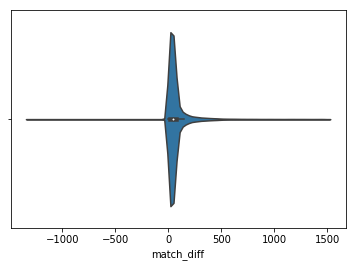

In [31]:
sns.violinplot(x='match_diff', data=gps_by_boarding_filtered[(gps_by_boarding_filtered['match_diff'] > -max_match_diff) & (gps_by_boarding_filtered['match_diff'] < max_match_diff)])

In [32]:
num_total_boardings = len(gps_by_boarding[pd.notnull(gps_by_boarding['cardNum'])])
num_single_boardings = len(gps_by_boarding.drop_duplicates(subset=boarding_key_cols))
num_matched_boardings = len(gps_by_boarding_filtered)
num_missed_boardings = num_single_boardings - num_matched_boardings
perc_matched_boardings = num_matched_boardings/float(num_single_boardings)
perc_missed_boardings = num_missed_boardings/float(num_single_boardings)
print "total_boardings: {}, single boardings: {}, matched boardings: {} ({}), missed boardings = {} ({})".format(num_total_boardings, num_single_boardings, num_matched_boardings, perc_matched_boardings, num_missed_boardings, perc_missed_boardings)

total_boardings: 144668, single boardings: 144668, matched boardings: 139531 (0.964491110681), missed boardings = 5137 (0.035508889319)


In [33]:
all_boardings = gps_by_boarding[boarding_key_cols].drop_duplicates()
matched_boardings = gps_by_boarding_filtered[boarding_key_cols].drop_duplicates()
missed_boardings = pd.concat([all_boardings,matched_boardings]).drop_duplicates(keep=False)
print len(missed_boardings)
missed_boardings

5137


,cardNum,boarding_datetime
376450,304627.0,2017-05-09 16:24:40
510050,324875.0,2017-05-09 05:33:32
271115,326132.0,2017-05-09 14:24:16
391172,327480.0,2017-05-09 06:22:12
128240,328903.0,2017-05-09 07:20:03
542840,335655.0,2017-05-09 08:37:38
391175,336277.0,2017-05-09 05:54:39
613942,336525.0,2017-05-09 08:57:37
613941,336525.0,2017-05-09 08:57:43
341510,352479.0,2017-05-09 17:26:00


In [34]:
gps_by_boarding_missed = gps_by_boarding.merge(missed_boardings, on=boarding_key_cols, how='inner')
print len(gps_by_boarding_missed)

5137


In [35]:
gps_by_boarding_missed

,cardNum,boarding_datetime,gps_datetime,route,busCode,stopPointId,tripNum,shapeId,shapeSequence,shapeLat,...,gpsLon,distanceToShapePoint,timestamp,problem,birthdate,cardTimestamp,lineName,gender,date,match_diff
0,304627.0,2017-05-09 16:24:40,2017-05-09 15:45:37,370,LC020,30303,6.0,2789,5510843,-25.455839,...,-49.323013,5.475631,15:45:37,NO_PROBLEM,05/04/53,16:24:40,RUA XV / BARIGUI,F,2017-05-09,2343.0
1,324875.0,2017-05-09 05:33:32,2017-05-09 12:58:40,631,GA208,33278,8.0,3369,6595274,-25.512413,...,-49.289261,3.034185,12:58:40,NO_PROBLEM,27/02/77,05:33:32,RIO NEGRO,F,2017-05-09,-26708.0
2,326132.0,2017-05-09 14:24:16,2017-05-09 13:47:36,370,LC028,30304,5.0,2789,5510857,-25.458703,...,-49.323503,2.649607,13:47:36,NO_PROBLEM,15/02/85,14:24:16,RUA XV / BARIGUI,F,2017-05-09,2200.0
3,327480.0,2017-05-09 06:22:12,2017-05-09 12:59:59,040,HB605,34156,3.0,1718,3368987,-25.404344,...,-49.335390,10.035853,12:59:59,NO_PROBLEM,04/04/77,06:22:12,INTERBAIRROS IV,F,2017-05-09,-23867.0
4,328903.0,2017-05-09 07:20:03,2017-05-09 06:51:17,021,HB604,28136,1.0,3235,5233298,-25.435866,...,-49.307076,20.858232,06:51:17,NO_PROBLEM,22/04/78,07:20:03,OP. CONTIGENCIA,M,2017-05-09,1726.0
5,335655.0,2017-05-09 08:37:38,2017-05-09 07:55:32,010,BB310,33171,2.0,1708,5859650,-25.449428,...,-49.254205,8.176641,07:55:32,NO_PROBLEM,21/04/51,08:37:38,INTERBAIRROS I H,F,2017-05-09,2526.0
6,336277.0,2017-05-09 05:54:39,2017-05-09 12:59:59,040,HB605,34156,3.0,1718,3368987,-25.404344,...,-49.335390,10.035853,12:59:59,NO_PROBLEM,28/01/69,05:54:39,INTERBAIRROS IV,F,2017-05-09,-25520.0
7,336525.0,2017-05-09 08:57:37,2017-05-09 08:15:39,010,BB001,33171,3.0,1708,5859650,-25.449428,...,-49.254193,6.699659,08:15:39,NO_PROBLEM,03/08/78,08:57:37,INTERBAIRROS I H,F,2017-05-09,2518.0
8,336525.0,2017-05-09 08:57:43,2017-05-09 08:15:39,010,BB001,33171,3.0,1708,5859650,-25.449428,...,-49.254193,6.699659,08:15:39,NO_PROBLEM,03/08/78,08:57:43,INTERBAIRROS I H,F,2017-05-09,2524.0
9,352479.0,2017-05-09 17:26:00,2017-05-09 16:25:38,040,MB301,31029,8.0,1717,3367323,-25.513207,...,-49.295160,3.268860,16:25:38,NO_PROBLEM,10/10/51,17:26:00,INTERBAIRROS IV,M,2017-05-09,3622.0


#### Check the distribution of match_diff variable to evaluate the effectiveness of the threshold value

In [36]:
best_missed_boarding_matches = gps_by_boarding_missed.copy()
#best_missed_boarding_matches['match_diff'] = np.abs(best_missed_boarding_matches['match_diff'])
best_missed_boarding_matches = best_missed_boarding_matches.loc[best_missed_boarding_matches.groupby(['cardNum','boarding_datetime'])['match_diff'].idxmin()]
best_missed_boarding_matches = best_missed_boarding_matches[best_missed_boarding_matches['match_diff'] > 0]
best_missed_boarding_matches['match_diff'] = ((best_missed_boarding_matches['match_diff']-3600)/60)
best_missed_boarding_matches['match_diff'].describe()

count    2848.000000
mean       57.201486
std       153.344112
min       -34.983333
25%       -27.750000
50%       -14.191667
75%        46.387500
max       535.133333
Name: match_diff, dtype: float64

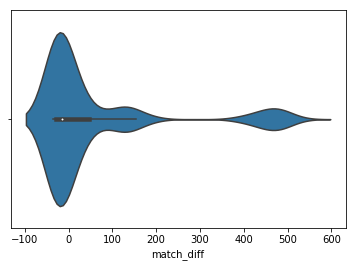

In [37]:
sns.violinplot(x="match_diff", data=best_missed_boarding_matches)

In [38]:
total_gps_data = len(gps_data)
gps_key_cols = ['route','busCode','tripNum','stopPointId']
gps_single_records = gps_data.dropna(subset=gps_key_cols).drop_duplicates(subset=gps_key_cols)
gps_with_no_boarding = gps_single_records[np.isnan(gps_single_records['cardNum'])]
num_single_gps_records = len(gps_single_records)
num_gps_no_boarding = len(gps_with_no_boarding)

print "total gps data: {}, num single GPS records: {}, num single GPS with no boarding: {} ({}), diff: {}" \
    .format(total_gps_data, num_single_gps_records, num_gps_no_boarding, 
            num_gps_no_boarding/float(num_single_gps_records), 
            num_single_gps_records - num_gps_no_boarding)

total gps data: 642639, num single GPS records: 537229, num single GPS with no boarding: 470562 (0.875905805532), diff: 66667


#### Create GPS-boarding dataframe containing all unique GPS records and unique selected boarding records

In [37]:
missed_boarding_gps = gps_by_boarding_missed.copy()
missed_boarding_gps[['birthdate','cardTimestamp','lineName','cardNum','gender','boarding_datetime']] = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]

In [38]:
missed_boarding_gps

,cardNum,boarding_datetime,gps_datetime,route,busCode,stopPointId,tripNum,shapeId,shapeSequence,shapeLat,...,gpsLon,distanceToShapePoint,timestamp,problem,birthdate,cardTimestamp,lineName,gender,date,match_diff
0,NaN,NaN,2017-05-09 15:45:37,370,LC020,30303,6.0,2789,5510843,-25.455839,...,-49.323013,5.475631,15:45:37,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,2343.0
1,NaN,NaN,2017-05-09 12:58:40,631,GA208,33278,8.0,3369,6595274,-25.512413,...,-49.289261,3.034185,12:58:40,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,-26708.0
2,NaN,NaN,2017-05-09 13:47:36,370,LC028,30304,5.0,2789,5510857,-25.458703,...,-49.323503,2.649607,13:47:36,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,2200.0
3,NaN,NaN,2017-05-09 12:59:59,040,HB605,34156,3.0,1718,3368987,-25.404344,...,-49.335390,10.035853,12:59:59,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,-23867.0
4,NaN,NaN,2017-05-09 06:51:17,021,HB604,28136,1.0,3235,5233298,-25.435866,...,-49.307076,20.858232,06:51:17,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,1726.0
5,NaN,NaN,2017-05-09 07:55:32,010,BB310,33171,2.0,1708,5859650,-25.449428,...,-49.254205,8.176641,07:55:32,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,2526.0
6,NaN,NaN,2017-05-09 12:59:59,040,HB605,34156,3.0,1718,3368987,-25.404344,...,-49.335390,10.035853,12:59:59,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,-25520.0
7,NaN,NaN,2017-05-09 08:15:39,010,BB001,33171,3.0,1708,5859650,-25.449428,...,-49.254193,6.699659,08:15:39,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,2518.0
8,NaN,NaN,2017-05-09 08:15:39,010,BB001,33171,3.0,1708,5859650,-25.449428,...,-49.254193,6.699659,08:15:39,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,2524.0
9,NaN,NaN,2017-05-09 16:25:38,040,MB301,31029,8.0,1717,3367323,-25.513207,...,-49.295160,3.268860,16:25:38,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,3622.0


In [39]:
print missed_boarding_gps.columns
print gps_with_no_boarding[cols_order].columns

Index([u'cardNum', u'boarding_datetime', u'gps_datetime', u'route', u'busCode',
       u'stopPointId', u'tripNum', u'shapeId', u'shapeSequence', u'shapeLat',
       u'shapeLon', u'distanceTraveledShape', u'gpsPointId', u'gpsLat',
       u'gpsLon', u'distanceToShapePoint', u'timestamp', u'problem',
       u'birthdate', u'cardTimestamp', u'lineName', u'gender', u'date',
       u'match_diff'],
      dtype='object')
Index([u'cardNum', u'boarding_datetime', u'gps_datetime', u'route', u'busCode',
       u'stopPointId', u'tripNum', u'shapeId', u'shapeSequence', u'shapeLat',
       u'shapeLon', u'distanceTraveledShape', u'gpsPointId', u'gpsLat',
       u'gpsLon', u'distanceToShapePoint', u'timestamp', u'problem',
       u'birthdate', u'cardTimestamp', u'lineName', u'gender', u'date'],
      dtype='object')


In [40]:
gps_with_no_boarding = gps_with_no_boarding[cols_order]
gps_with_no_boarding['match_diff'] = np.nan
gps_without_or_notselected_boarding = pd.concat([gps_with_no_boarding, missed_boarding_gps], axis=0) \
            .drop_duplicates(subset=gps_key_cols)
gps_without_or_notselected_boarding

,cardNum,boarding_datetime,gps_datetime,route,busCode,stopPointId,tripNum,shapeId,shapeSequence,shapeLat,...,gpsLon,distanceToShapePoint,timestamp,problem,birthdate,cardTimestamp,lineName,gender,date,match_diff
0,NaN,NaT,2017-05-09 12:00:03,372,CC170,30778,4.0,1891,6136674,-25.418008,...,NaN,NaN,12:00:03,BETWEEN,NaN,NaN,NaN,NaN,2017-05-09,NaN
1,NaN,NaT,2017-05-09 12:00:52,372,CC170,30767,4.0,1891,6136668,-25.416008,...,NaN,NaN,12:00:52,BETWEEN,NaN,NaN,NaN,NaN,2017-05-09,NaN
2,NaN,NaT,2017-05-09 12:02:16,372,CC170,30760,4.0,1891,6136658,-25.413175,...,NaN,NaN,12:02:16,BETWEEN,NaN,NaN,NaN,NaN,2017-05-09,NaN
3,NaN,NaT,2017-05-09 12:03:22,372,CC170,26210,4.0,1891,6136644,-25.412986,...,-49.205350,11.568364,12:03:22,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,NaN
4,NaN,NaT,2017-05-09 12:04:49,372,CC170,30760,5.0,1891,6136658,-25.413175,...,-49.203728,24.480747,12:04:49,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,NaN
5,NaN,NaT,2017-05-09 12:05:40,372,CC170,30767,5.0,1891,6136668,-25.416008,...,NaN,NaN,12:05:40,BETWEEN,NaN,NaN,NaN,NaN,2017-05-09,NaN
6,NaN,NaT,2017-05-09 12:06:23,372,CC170,30778,5.0,1891,6136674,-25.418008,...,-49.201195,13.330036,12:06:23,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,NaN
7,NaN,NaT,2017-05-09 12:06:46,372,CC170,30780,5.0,1891,6136679,-25.419443,...,-49.200441,13.122053,12:06:46,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,NaN
9,NaN,NaT,2017-05-09 12:09:23,372,CC170,30784,5.0,1891,6136696,-25.423411,...,-49.201908,11.065555,12:09:23,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,NaN
12,NaN,NaT,2017-05-09 12:11:13,372,CC170,30817,5.0,1891,6136720,-25.428213,...,NaN,NaN,12:11:13,BETWEEN,NaN,NaN,NaN,NaN,2017-05-09,NaN


In [41]:
gps_without_or_notselected_boarding.columns

Index([u'cardNum', u'boarding_datetime', u'gps_datetime', u'route', u'busCode',
       u'stopPointId', u'tripNum', u'shapeId', u'shapeSequence', u'shapeLat',
       u'shapeLon', u'distanceTraveledShape', u'gpsPointId', u'gpsLat',
       u'gpsLon', u'distanceToShapePoint', u'timestamp', u'problem',
       u'birthdate', u'cardTimestamp', u'lineName', u'gender', u'date',
       u'match_diff'],
      dtype='object')

In [42]:
print "num unique GPS records not matched: {}".format(len(gps_without_or_notselected_boarding))

num unique GPS records not matched: 471091


In [43]:
print gps_by_boarding_filtered.columns
print gps_without_or_notselected_boarding.columns

Index([u'cardNum', u'boarding_datetime', u'gps_datetime', u'route', u'busCode',
       u'stopPointId', u'tripNum', u'shapeId', u'shapeSequence', u'shapeLat',
       u'shapeLon', u'distanceTraveledShape', u'gpsPointId', u'gpsLat',
       u'gpsLon', u'distanceToShapePoint', u'timestamp', u'problem',
       u'birthdate', u'cardTimestamp', u'lineName', u'gender', u'date',
       u'match_diff'],
      dtype='object')
Index([u'cardNum', u'boarding_datetime', u'gps_datetime', u'route', u'busCode',
       u'stopPointId', u'tripNum', u'shapeId', u'shapeSequence', u'shapeLat',
       u'shapeLon', u'distanceTraveledShape', u'gpsPointId', u'gpsLat',
       u'gpsLon', u'distanceToShapePoint', u'timestamp', u'problem',
       u'birthdate', u'cardTimestamp', u'lineName', u'gender', u'date',
       u'match_diff'],
      dtype='object')


In [44]:
boarding_gps_key_cols = boarding_key_cols + gps_key_cols
buste_fixed_result = pd.concat([gps_by_boarding_filtered, gps_without_or_notselected_boarding]) \
                        .drop_duplicates(subset=boarding_gps_key_cols) \
                        .reset_index(drop=True)
buste_fixed_result

,cardNum,boarding_datetime,gps_datetime,route,busCode,stopPointId,tripNum,shapeId,shapeSequence,shapeLat,...,gpsLon,distanceToShapePoint,timestamp,problem,birthdate,cardTimestamp,lineName,gender,date,match_diff
0,229948.0,2017-05-09 06:29:09,2017-05-09 06:28:49,654,HA017,35350,2.0,2953,3848651,-25.492612,...,NaN,NaN,06:28:49,BETWEEN,28/04/95,06:29:09,CAMPO ALEGRE,F,2017-05-09,20.0
1,257342.0,2017-05-09 07:48:58,2017-05-09 07:47:51,511,EA172,31195,4.0,2746,5846156,-25.498727,...,-49.247771,9.667548,07:47:51,NO_PROBLEM,24/01/71,07:48:58,SÃO FRANCISCO,F,2017-05-09,67.0
2,300327.0,2017-05-09 06:56:45,2017-05-09 06:55:54,654,HA240,36094,3.0,2106,6040871,-25.501307,...,-49.319971,0.737270,06:55:54,NO_PROBLEM,20/05/59,06:56:45,OP. CONTIGENCIA,F,2017-05-09,51.0
3,304127.0,2017-05-09 10:24:50,2017-05-09 10:22:28,175,BC010,31748,5.0,1743,5444496,-25.450869,...,-49.254015,13.270845,10:22:28,NO_PROBLEM,09/06/54,10:24:50,BOM RETIRO / PUC,M,2017-05-09,142.0
4,304127.0,2017-05-09 10:57:36,2017-05-09 10:42:18,370,LC016,3377,3.0,3669,6592154,-25.428220,...,-49.246896,5.426374,10:42:18,NO_PROBLEM,09/06/54,10:57:36,RUA XV / BARIGUI,M,2017-05-09,918.0
5,304627.0,2017-05-09 14:17:23,2017-05-09 14:16:09,370,BC032,3377,6.0,2789,5510110,-25.428214,...,-49.246675,18.124441,14:16:09,NO_PROBLEM,05/04/53,14:17:23,RUA XV / BARIGUI,F,2017-05-09,74.0
6,306135.0,2017-05-09 07:56:49,2017-05-09 07:56:48,777,JC004,32097,3.0,2194,4299781,-25.446370,...,-49.275308,32.238018,07:56:48,NO_PROBLEM,29/10/52,07:56:49,V. VELHA,M,2017-05-09,1.0
7,310241.0,2017-05-09 17:55:48,2017-05-09 17:55:42,468,DC090,30884,5.0,1926,4418132,-25.455683,...,-49.241156,8.323350,17:55:42,NO_PROBLEM,13/01/72,17:55:48,JD. ITIBERÊ,M,2017-05-09,6.0
8,312500.0,2017-05-09 13:26:11,2017-05-09 13:24:48,175,BC282,28632,6.0,2743,5404932,-25.431576,...,-49.271680,6.383659,13:24:48,NO_PROBLEM,26/02/82,13:26:11,BOM RETIRO / PUC,F,2017-05-09,83.0
9,312823.0,2017-05-09 13:35:49,2017-05-09 13:34:57,652,LA001,34977,13.0,2101,3834325,-25.534607,...,-49.331276,14.430964,13:34:57,NO_PROBLEM,03/09/88,13:35:49,V. VERDE,F,2017-05-09,52.0


### Match BUSTE GPS entries with their respective parent stop codes

#### Read GTFS stops file

In [45]:
stops_df = pd.read_csv('/local/tarciso/data/gtfs/curitiba/stops.txt')

In [46]:
stops_df.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding
0,70,104505,Terminal Campina do Siqueira - 303 - Centenári...,Terminal Campina do Siqueira - Campo Comprido,-25.435724,-49.306998,NaN,NaN,0,14506.0,NaN,NaN
1,270,104905,Terminal Carmo - 030 - Interbairros III,Terminal Carmo - 030 - Interbairros III (Senti...,-25.501341,-49.237597,NaN,NaN,0,14485.0,NaN,NaN
2,276,105606,Terminal Oficinas - 030 - Interbairros III,Terminal Oficinas - 030 - Interbairros III (Se...,-25.451550,-49.214917,NaN,NaN,0,14481.0,NaN,NaN
3,299,105603,Terminal Oficinas - 030 - Interbairros III,Terminal Oficinas - 030 - Interbairros III (Se...,-25.451665,-49.215086,NaN,NaN,0,14481.0,NaN,NaN
4,308,104907,Terminal Carmo - 030 - Interbairros III,Terminal Carmo - 030 - Interbairros III (Senti...,-25.501311,-49.237825,NaN,NaN,0,14485.0,NaN,NaN


In [47]:
stops_parent_stations = stops_df[['stop_id','parent_station']]

#### Add parent station ID to GPS Boardings data

In [48]:
gps_stops_with_parent_stations = buste_fixed_result.merge(stops_parent_stations, left_on='stopPointId', right_on='stop_id', how='left')

In [49]:
gps_stops_with_parent_stations.head()

,cardNum,boarding_datetime,gps_datetime,route,busCode,stopPointId,tripNum,shapeId,shapeSequence,shapeLat,...,timestamp,problem,birthdate,cardTimestamp,lineName,gender,date,match_diff,stop_id,parent_station
0,229948.0,2017-05-09 06:29:09,2017-05-09 06:28:49,654,HA017,35350,2.0,2953,3848651,-25.492612,...,06:28:49,BETWEEN,28/04/95,06:29:09,CAMPO ALEGRE,F,2017-05-09,20.0,35350.0,NaN
1,257342.0,2017-05-09 07:48:58,2017-05-09 07:47:51,511,EA172,31195,4.0,2746,5846156,-25.498727,...,07:47:51,NO_PROBLEM,24/01/71,07:48:58,SÃO FRANCISCO,F,2017-05-09,67.0,31195.0,NaN
2,300327.0,2017-05-09 06:56:45,2017-05-09 06:55:54,654,HA240,36094,3.0,2106,6040871,-25.501307,...,06:55:54,NO_PROBLEM,20/05/59,06:56:45,OP. CONTIGENCIA,F,2017-05-09,51.0,36094.0,NaN
3,304127.0,2017-05-09 10:24:50,2017-05-09 10:22:28,175,BC010,31748,5.0,1743,5444496,-25.450869,...,10:22:28,NO_PROBLEM,09/06/54,10:24:50,BOM RETIRO / PUC,M,2017-05-09,142.0,31748.0,NaN
4,304127.0,2017-05-09 10:57:36,2017-05-09 10:42:18,370,LC016,3377,3.0,3669,6592154,-25.428220,...,10:42:18,NO_PROBLEM,09/06/54,10:57:36,RUA XV / BARIGUI,M,2017-05-09,918.0,3377.0,NaN


In [50]:
num_records_with_parent_station = len(gps_stops_with_parent_stations[np.logical_not(np.isnan(gps_stops_with_parent_stations['parent_station']))])
total_num_gps_records = len(gps_stops_with_parent_stations)
print "Num stops with parent station: {} ({})".format(num_records_with_parent_station, num_records_with_parent_station/float(total_num_gps_records))
print "Num stop GPS records: {}".format(len(gps_stops_with_parent_stations))

Num stops with parent station: 77535 (0.126977082385)
Num stop GPS records: 610622


#### Concatenate line 000 boardings with GPS boardings

In [51]:
matched_000_stations.head()

,CODLINHA,NOMELINHA,CODVEICULO,NUMEROCARTAO,HORAUTILIZACAO,DATAUTILIZACAO,DATANASCIMENTO,SEXO,boarding_datetime,LINE,NAME,URBS_CODE,STOP_ID,LAT,LON
0,000,OPER S/LINHA,00070,1353891,11:05:57,09/05/17,22/11/58,M,2017-05-09 11:05:57,000,TERMINAL HAUER,00070,14487,-25.481900,-49.247078
81916,000,OPER S/LINHA,03036,3103755,07:06:52,09/05/17,14/01/96,F,2017-05-09 07:06:52,000,ESTAÇÃO SILVA JARDIM - SENT. CENTRO,03036,26105,-25.448323,-49.287777
81915,000,OPER S/LINHA,03036,3476595,15:54:33,09/05/17,27/11/92,M,2017-05-09 15:54:33,000,ESTAÇÃO SILVA JARDIM - SENT. CENTRO,03036,26105,-25.448323,-49.287777
81914,000,OPER S/LINHA,03036,3772075,18:08:20,09/05/17,27/10/84,F,2017-05-09 18:08:20,000,ESTAÇÃO SILVA JARDIM - SENT. CENTRO,03036,26105,-25.448323,-49.287777
81913,000,OPER S/LINHA,03036,3483992,16:16:02,09/05/17,26/08/90,M,2017-05-09 16:16:02,000,ESTAÇÃO SILVA JARDIM - SENT. CENTRO,03036,26105,-25.448323,-49.287777


In [52]:
line_000_boardings = matched_000_stations.drop(['LINE','NAME','URBS_CODE','LAT','LON','boarding_datetime','DATAUTILIZACAO'], axis=1) \
                        .rename(index=str, columns={'CODLINHA': 'route', 'CODVEICULO': 'busCode', 
                                                    'DATANASCIMENTO':'birthdate','HORAUTILIZACAO':'cardTimestamp',
                                                    'NOMELINHA':'lineName','NUMEROCARTAO':'cardNum',
                                                     'SEXO':'gender','STOP_ID':'stopPointId'})

In [53]:
line_000_boardings.head()

,route,lineName,busCode,cardNum,cardTimestamp,birthdate,gender,stopPointId
0,000,OPER S/LINHA,00070,1353891,11:05:57,22/11/58,M,14487
81916,000,OPER S/LINHA,03036,3103755,07:06:52,14/01/96,F,26105
81915,000,OPER S/LINHA,03036,3476595,15:54:33,27/11/92,M,26105
81914,000,OPER S/LINHA,03036,3772075,18:08:20,27/10/84,F,26105
81913,000,OPER S/LINHA,03036,3483992,16:16:02,26/08/90,M,26105


In [54]:
print "Num line 000 boarding with stations: {}".format(len(line_000_boardings))

Num line 000 boarding with stations: 122864


In [55]:
gps_stops_with_parent_stations.columns

Index([u'cardNum', u'boarding_datetime', u'gps_datetime', u'route', u'busCode',
       u'stopPointId', u'tripNum', u'shapeId', u'shapeSequence', u'shapeLat',
       u'shapeLon', u'distanceTraveledShape', u'gpsPointId', u'gpsLat',
       u'gpsLon', u'distanceToShapePoint', u'timestamp', u'problem',
       u'birthdate', u'cardTimestamp', u'lineName', u'gender', u'date',
       u'match_diff', u'stop_id', u'parent_station'],
      dtype='object')

In [56]:
print "Num GPS stops with parent stations: {}".format(len(gps_stops_with_parent_stations))

Num GPS stops with parent stations: 610622


In [57]:
gps_boardings_with_000 = pd.concat([gps_stops_with_parent_stations,line_000_boardings]) \
                            .drop('stop_id', axis=1)

In [58]:
gps_boardings_with_000 = gps_boardings_with_000[['route','busCode','tripNum','stopPointId','parent_station','cardNum','cardTimestamp','gps_datetime',
                                      'shapeId','shapeSequence','shapeLat','shapeLon','distanceTraveledShape','gpsPointId',
                                      'gpsLat','gpsLon','distanceToShapePoint','timestamp','problem','lineName','birthdate',
                                      'lineName','gender','date']] \
                            .sort_values(['cardNum','cardTimestamp'])

In [59]:
gps_boardings_with_000

,route,busCode,tripNum,stopPointId,parent_station,cardNum,cardTimestamp,gps_datetime,shapeId,shapeSequence,...,gpsLat,gpsLon,distanceToShapePoint,timestamp,problem,lineName,birthdate,lineName,gender,date
109722,000,08024,NaN,41752,NaN,228696.0,07:01:00,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,27/04/94,OPER S/LINHA,F,NaT
0,654,HA017,2.0,35350,NaN,229948.0,06:29:09,2017-05-09 06:28:49,2953.0,3848651.0,...,NaN,NaN,NaN,06:28:49,BETWEEN,CAMPO ALEGRE,28/04/95,CAMPO ALEGRE,F,2017-05-09
21774,000,01026,NaN,41863,NaN,233641.0,06:39:21,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,20/09/96,OPER S/LINHA,F,NaT
1,511,EA172,4.0,31195,NaN,257342.0,07:48:58,2017-05-09 07:47:51,2746.0,5846156.0,...,-25.498735,-49.247771,9.667548,07:47:51,NO_PROBLEM,SÃO FRANCISCO,24/01/71,SÃO FRANCISCO,F,2017-05-09
113863,000,01021,NaN,26037,NaN,257342.0,17:24:51,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,24/01/71,OPER S/LINHA,F,NaT
41369,000,03047,NaN,14553,NaN,272904.0,17:24:52,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,17/09/74,OPER S/LINHA,F,NaT
2,654,HA240,3.0,36094,NaN,300327.0,06:56:45,2017-05-09 06:55:54,2106.0,6040871.0,...,-25.501313,-49.319971,0.737270,06:55:54,NO_PROBLEM,OP. CONTIGENCIA,20/05/59,OP. CONTIGENCIA,F,2017-05-09
27672,000,00038,NaN,26051,NaN,303661.0,17:43:10,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,23/06/73,OPER S/LINHA,M,NaT
3,175,BC010,5.0,31748,NaN,304127.0,10:24:50,2017-05-09 10:22:28,1743.0,5444496.0,...,-25.450986,-49.254015,13.270845,10:22:28,NO_PROBLEM,BOM RETIRO / PUC,09/06/54,BOM RETIRO / PUC,M,2017-05-09
4,370,LC016,3.0,3377,NaN,304127.0,10:57:36,2017-05-09 10:42:18,3669.0,6592154.0,...,-25.428210,-49.246896,5.426374,10:42:18,NO_PROBLEM,RUA XV / BARIGUI,09/06/54,RUA XV / BARIGUI,M,2017-05-09


In [60]:
buste_final_result = gps_boardings_with_000.copy()
size_buste_final_result = len(buste_final_result)

In [61]:
selected_gps_and_boarding_matches = buste_final_result[pd.notnull(buste_final_result.cardNum) & pd.notnull(buste_final_result.gps_datetime)]
num_selected_gps_and_boarding_matches = len(selected_gps_and_boarding_matches)

print "Number of GPS and Boarding matches: {} ({})".format(num_selected_gps_and_boarding_matches,num_selected_gps_and_boarding_matches/(float(size_buste_final_result)))
selected_gps_and_boarding_matches.head(10)

Number of GPS and Boarding matches: 139531 (0.190229943039)


,route,busCode,tripNum,stopPointId,parent_station,cardNum,cardTimestamp,gps_datetime,shapeId,shapeSequence,...,gpsLat,gpsLon,distanceToShapePoint,timestamp,problem,lineName,birthdate,lineName,gender,date
0,654,HA017,2.0,35350,NaN,229948.0,06:29:09,2017-05-09 06:28:49,2953.0,3848651.0,...,NaN,NaN,NaN,06:28:49,BETWEEN,CAMPO ALEGRE,28/04/95,CAMPO ALEGRE,F,2017-05-09
1,511,EA172,4.0,31195,NaN,257342.0,07:48:58,2017-05-09 07:47:51,2746.0,5846156.0,...,-25.498735,-49.247771,9.667548,07:47:51,NO_PROBLEM,SÃO FRANCISCO,24/01/71,SÃO FRANCISCO,F,2017-05-09
2,654,HA240,3.0,36094,NaN,300327.0,06:56:45,2017-05-09 06:55:54,2106.0,6040871.0,...,-25.501313,-49.319971,0.737270,06:55:54,NO_PROBLEM,OP. CONTIGENCIA,20/05/59,OP. CONTIGENCIA,F,2017-05-09
3,175,BC010,5.0,31748,NaN,304127.0,10:24:50,2017-05-09 10:22:28,1743.0,5444496.0,...,-25.450986,-49.254015,13.270845,10:22:28,NO_PROBLEM,BOM RETIRO / PUC,09/06/54,BOM RETIRO / PUC,M,2017-05-09
4,370,LC016,3.0,3377,NaN,304127.0,10:57:36,2017-05-09 10:42:18,3669.0,6592154.0,...,-25.428210,-49.246896,5.426374,10:42:18,NO_PROBLEM,RUA XV / BARIGUI,09/06/54,RUA XV / BARIGUI,M,2017-05-09
5,370,BC032,6.0,3377,NaN,304627.0,14:17:23,2017-05-09 14:16:09,2789.0,5510110.0,...,-25.428125,-49.246675,18.124441,14:16:09,NO_PROBLEM,RUA XV / BARIGUI,05/04/53,RUA XV / BARIGUI,F,2017-05-09
6,777,JC004,3.0,32097,NaN,306135.0,07:56:49,2017-05-09 07:56:48,2194.0,4299781.0,...,-25.446305,-49.275308,32.238018,07:56:48,NO_PROBLEM,V. VELHA,29/10/52,V. VELHA,M,2017-05-09
7,468,DC090,5.0,30884,NaN,310241.0,17:55:48,2017-05-09 17:55:42,1926.0,4418132.0,...,-25.455618,-49.241156,8.323350,17:55:42,NO_PROBLEM,JD. ITIBERÊ,13/01/72,JD. ITIBERÊ,M,2017-05-09
8,175,BC282,6.0,28632,NaN,312500.0,13:26:11,2017-05-09 13:24:48,2743.0,5404932.0,...,-25.431573,-49.271680,6.383659,13:24:48,NO_PROBLEM,BOM RETIRO / PUC,26/02/82,BOM RETIRO / PUC,F,2017-05-09
9,652,LA001,13.0,34977,NaN,312823.0,13:35:49,2017-05-09 13:34:57,2101.0,3834325.0,...,-25.534736,-49.331276,14.430964,13:34:57,NO_PROBLEM,V. VERDE,03/09/88,V. VERDE,F,2017-05-09


In [62]:
gps_without_boarding = buste_final_result[pd.isnull(buste_final_result.cardNum) & pd.notnull(buste_final_result.gps_datetime)]
num_gps_without_boarding = len(gps_without_boarding)

print "Number of GPS records without boarding: {} ({})".format(num_gps_without_boarding,num_gps_without_boarding/(float(size_buste_final_result)))
gps_without_boarding.head(10)

Number of GPS records without boarding: 471091 (0.64226311068)


,route,busCode,tripNum,stopPointId,parent_station,cardNum,cardTimestamp,gps_datetime,shapeId,shapeSequence,...,gpsLat,gpsLon,distanceToShapePoint,timestamp,problem,lineName,birthdate,lineName,gender,date
139531,372,CC170,4.0,30778,NaN,NaN,NaN,2017-05-09 12:00:03,1891.0,6136674.0,...,NaN,NaN,NaN,12:00:03,BETWEEN,NaN,NaN,NaN,NaN,2017-05-09
139532,372,CC170,4.0,30767,NaN,NaN,NaN,2017-05-09 12:00:52,1891.0,6136668.0,...,NaN,NaN,NaN,12:00:52,BETWEEN,NaN,NaN,NaN,NaN,2017-05-09
139533,372,CC170,4.0,30760,NaN,NaN,NaN,2017-05-09 12:02:16,1891.0,6136658.0,...,NaN,NaN,NaN,12:02:16,BETWEEN,NaN,NaN,NaN,NaN,2017-05-09
139534,372,CC170,4.0,26210,14476.0,NaN,NaN,2017-05-09 12:03:22,1891.0,6136644.0,...,-25.413055,-49.205350,11.568364,12:03:22,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09
139535,372,CC170,5.0,30760,NaN,NaN,NaN,2017-05-09 12:04:49,1891.0,6136658.0,...,-25.413151,-49.203728,24.480747,12:04:49,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09
139536,372,CC170,5.0,30767,NaN,NaN,NaN,2017-05-09 12:05:40,1891.0,6136668.0,...,NaN,NaN,NaN,12:05:40,BETWEEN,NaN,NaN,NaN,NaN,2017-05-09
139537,372,CC170,5.0,30778,NaN,NaN,NaN,2017-05-09 12:06:23,1891.0,6136674.0,...,-25.417930,-49.201195,13.330036,12:06:23,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09
139538,372,CC170,5.0,30780,NaN,NaN,NaN,2017-05-09 12:06:46,1891.0,6136679.0,...,-25.419556,-49.200441,13.122053,12:06:46,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09
139539,372,CC170,5.0,30784,NaN,NaN,NaN,2017-05-09 12:09:23,1891.0,6136696.0,...,-25.423435,-49.201908,11.065555,12:09:23,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09
139540,372,CC170,5.0,30817,NaN,NaN,NaN,2017-05-09 12:11:13,1891.0,6136720.0,...,NaN,NaN,NaN,12:11:13,BETWEEN,NaN,NaN,NaN,NaN,2017-05-09


In [63]:
boarding_without_gps = buste_final_result[pd.notnull(buste_final_result.cardNum) & pd.isnull(buste_final_result.gps_datetime)]
num_boarding_without_gps = len(boarding_without_gps)

print "Number of boarding records with no matched GPS: {} ({})".format(num_boarding_without_gps,num_boarding_without_gps/(float(size_buste_final_result)))
print "Percentage of boarding records to be matched to GPS: {}".format(num_boarding_without_gps/(float(num_boarding_without_gps + num_selected_gps_and_boarding_matches)))
boarding_without_gps.head(10)

Number of boarding records with no matched GPS: 122864 (0.167506946281)
Percentage of boarding records to be matched to GPS: 0.468240629585


,route,busCode,tripNum,stopPointId,parent_station,cardNum,cardTimestamp,gps_datetime,shapeId,shapeSequence,...,gpsLat,gpsLon,distanceToShapePoint,timestamp,problem,lineName,birthdate,lineName,gender,date
109722,000,08024,NaN,41752,NaN,228696.0,07:01:00,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,27/04/94,OPER S/LINHA,F,NaT
21774,000,01026,NaN,41863,NaN,233641.0,06:39:21,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,20/09/96,OPER S/LINHA,F,NaT
113863,000,01021,NaN,26037,NaN,257342.0,17:24:51,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,24/01/71,OPER S/LINHA,F,NaT
41369,000,03047,NaN,14553,NaN,272904.0,17:24:52,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,17/09/74,OPER S/LINHA,F,NaT
27672,000,00038,NaN,26051,NaN,303661.0,17:43:10,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,23/06/73,OPER S/LINHA,M,NaT
111178,000,09021,NaN,26112,NaN,304148.0,17:57:00,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,24/05/72,OPER S/LINHA,F,NaT
120416,000,05007,NaN,14517,NaN,305601.0,11:06:44,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,25/04/78,OPER S/LINHA,M,NaT
53052,000,00045,NaN,43723,NaN,305601.0,13:32:37,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,25/04/78,OPER S/LINHA,M,NaT
121786,000,06047,NaN,26057,NaN,306504.0,08:18:10,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,02/03/59,OPER S/LINHA,F,NaT
108774,000,05006,NaN,14471,NaN,307365.0,17:46:57,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,09/01/81,OPER S/LINHA,M,NaT


In [64]:
buste_final_result.head(20)

,route,busCode,tripNum,stopPointId,parent_station,cardNum,cardTimestamp,gps_datetime,shapeId,shapeSequence,...,gpsLat,gpsLon,distanceToShapePoint,timestamp,problem,lineName,birthdate,lineName,gender,date
109722,000,08024,NaN,41752,NaN,228696.0,07:01:00,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,27/04/94,OPER S/LINHA,F,NaT
0,654,HA017,2.0,35350,NaN,229948.0,06:29:09,2017-05-09 06:28:49,2953.0,3848651.0,...,NaN,NaN,NaN,06:28:49,BETWEEN,CAMPO ALEGRE,28/04/95,CAMPO ALEGRE,F,2017-05-09
21774,000,01026,NaN,41863,NaN,233641.0,06:39:21,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,20/09/96,OPER S/LINHA,F,NaT
1,511,EA172,4.0,31195,NaN,257342.0,07:48:58,2017-05-09 07:47:51,2746.0,5846156.0,...,-25.498735,-49.247771,9.667548,07:47:51,NO_PROBLEM,SÃO FRANCISCO,24/01/71,SÃO FRANCISCO,F,2017-05-09
113863,000,01021,NaN,26037,NaN,257342.0,17:24:51,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,24/01/71,OPER S/LINHA,F,NaT
41369,000,03047,NaN,14553,NaN,272904.0,17:24:52,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,17/09/74,OPER S/LINHA,F,NaT
2,654,HA240,3.0,36094,NaN,300327.0,06:56:45,2017-05-09 06:55:54,2106.0,6040871.0,...,-25.501313,-49.319971,0.737270,06:55:54,NO_PROBLEM,OP. CONTIGENCIA,20/05/59,OP. CONTIGENCIA,F,2017-05-09
27672,000,00038,NaN,26051,NaN,303661.0,17:43:10,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,23/06/73,OPER S/LINHA,M,NaT
3,175,BC010,5.0,31748,NaN,304127.0,10:24:50,2017-05-09 10:22:28,1743.0,5444496.0,...,-25.450986,-49.254015,13.270845,10:22:28,NO_PROBLEM,BOM RETIRO / PUC,09/06/54,BOM RETIRO / PUC,M,2017-05-09
4,370,LC016,3.0,3377,NaN,304127.0,10:57:36,2017-05-09 10:42:18,3669.0,6592154.0,...,-25.428210,-49.246896,5.426374,10:42:18,NO_PROBLEM,RUA XV / BARIGUI,09/06/54,RUA XV / BARIGUI,M,2017-05-09


#### Write BUSTE final result to file

In [65]:
buste_final_result.to_csv('/local/tarciso/masters/data/bus_trips/test/buste-05-09-2017_new.csv', index=False)

#### Analyze distribution of number of trips per user on a single day

In [66]:
trips_per_user = buste_final_result.groupby(['cardNum']).cardNum.count().reset_index(name='num_trips').num_trips.value_counts(normalize=True) \
                    .reset_index(name='num_trips', level=0)

In [67]:
trips_per_user

,index,num_trips
0,1,0.585762
1,2,0.319751
2,3,0.065268
3,4,0.022567
4,5,0.003731
5,6,0.002172
6,7,0.000372
7,8,0.000218
8,9,0.000100
9,10,0.000053


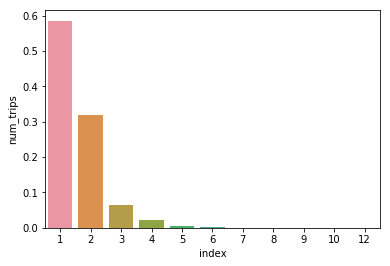

In [68]:
#sns.distplot(trips_per_user, hist=True)
#sns.violinplot(trips_per_user)
sns.barplot(x='index', y='num_trips', data=trips_per_user)

#### Compare with distribution of number of trips per user on a day on the original ticketing data

In [69]:
boarding_data.columns

Index([u'CODLINHA', u'NOMELINHA', u'CODVEICULO', u'NUMEROCARTAO',
       u'HORAUTILIZACAO', u'DATAUTILIZACAO', u'DATANASCIMENTO', u'SEXO',
       u'boarding_datetime'],
      dtype='object')

In [70]:
trips_per_user_original = boarding_data.groupby('NUMEROCARTAO').NUMEROCARTAO.count().reset_index(name='num_trips').num_trips.value_counts(normalize=True).reset_index(name='num_trips')

In [71]:
trips_per_user_original

,index,num_trips
0,1,0.500482
1,2,0.382923
2,3,0.078011
3,4,0.029663
4,5,0.004827
5,6,0.002977
6,7,0.000495
7,8,0.000396
8,9,0.000130
9,10,0.000094


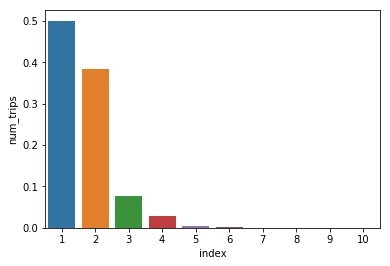

In [72]:
sns.barplot(x='index', y='num_trips', data=trips_per_user_original)

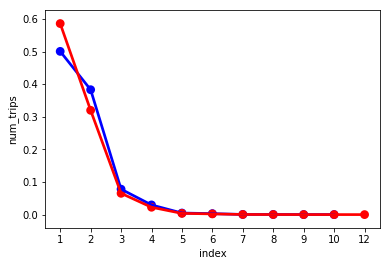

In [73]:
fig, ax = plt.subplots()
sns.pointplot(x='index', y='num_trips', data=trips_per_user_original, ax=ax, color='blue')
sns.pointplot(x='index', y='num_trips', data=trips_per_user, ax=ax, color='red')

#### Checking final BUSTE result boardings against original boardings

In [74]:
trips_original = len(boarding_data)
trips_buste_final = len(buste_final_result[pd.notnull(buste_final_result.cardNum)])
print "Num trips in original ticketing data: {}".format(trips_original)
print "Num trips in final BUSTE data: {} ({})".format(trips_buste_final, trips_buste_final/float(trips_original))
print "diff: {}".format(trips_original - trips_buste_final) 

Num trips in original ticketing data: 320292
Num trips in final BUSTE data: 262395 (0.8192368214)
diff: 57897


In [75]:
boarding_data[['NUMEROCARTAO','DATAUTILIZACAO','HORAUTILIZACAO','CODLINHA','CODVEICULO']] \
    .sort_values(['NUMEROCARTAO','HORAUTILIZACAO']).head(100)

,NUMEROCARTAO,DATAUTILIZACAO,HORAUTILIZACAO,CODLINHA,CODVEICULO
243380,228696,09/05/17,07:01:00,000,08024
243381,228696,09/05/17,13:55:35,000,05312
61748,229948,09/05/17,06:29:09,654,HA017
199681,233641,09/05/17,06:39:21,000,01026
199680,233641,09/05/17,12:08:17,021,04020
199752,257342,09/05/17,07:48:58,511,EA172
199751,257342,09/05/17,17:24:51,000,01021
14035,272904,09/05/17,17:24:52,000,03047
199773,300327,09/05/17,06:56:45,OPC,HA240
199772,300327,09/05/17,16:52:22,000,03057


In [76]:
buste_final_result.head(100)

,route,busCode,tripNum,stopPointId,parent_station,cardNum,cardTimestamp,gps_datetime,shapeId,shapeSequence,...,gpsLat,gpsLon,distanceToShapePoint,timestamp,problem,lineName,birthdate,lineName,gender,date
109722,000,08024,NaN,41752,NaN,228696.0,07:01:00,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,27/04/94,OPER S/LINHA,F,NaT
0,654,HA017,2.0,35350,NaN,229948.0,06:29:09,2017-05-09 06:28:49,2953.0,3848651.0,...,NaN,NaN,NaN,06:28:49,BETWEEN,CAMPO ALEGRE,28/04/95,CAMPO ALEGRE,F,2017-05-09
21774,000,01026,NaN,41863,NaN,233641.0,06:39:21,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,20/09/96,OPER S/LINHA,F,NaT
1,511,EA172,4.0,31195,NaN,257342.0,07:48:58,2017-05-09 07:47:51,2746.0,5846156.0,...,-25.498735,-49.247771,9.667548,07:47:51,NO_PROBLEM,SÃO FRANCISCO,24/01/71,SÃO FRANCISCO,F,2017-05-09
113863,000,01021,NaN,26037,NaN,257342.0,17:24:51,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,24/01/71,OPER S/LINHA,F,NaT
41369,000,03047,NaN,14553,NaN,272904.0,17:24:52,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,17/09/74,OPER S/LINHA,F,NaT
2,654,HA240,3.0,36094,NaN,300327.0,06:56:45,2017-05-09 06:55:54,2106.0,6040871.0,...,-25.501313,-49.319971,0.737270,06:55:54,NO_PROBLEM,OP. CONTIGENCIA,20/05/59,OP. CONTIGENCIA,F,2017-05-09
27672,000,00038,NaN,26051,NaN,303661.0,17:43:10,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,23/06/73,OPER S/LINHA,M,NaT
3,175,BC010,5.0,31748,NaN,304127.0,10:24:50,2017-05-09 10:22:28,1743.0,5444496.0,...,-25.450986,-49.254015,13.270845,10:22:28,NO_PROBLEM,BOM RETIRO / PUC,09/06/54,BOM RETIRO / PUC,M,2017-05-09
4,370,LC016,3.0,3377,NaN,304127.0,10:57:36,2017-05-09 10:42:18,3669.0,6592154.0,...,-25.428210,-49.246896,5.426374,10:42:18,NO_PROBLEM,RUA XV / BARIGUI,09/06/54,RUA XV / BARIGUI,M,2017-05-09


In [77]:
missed_ticketing = pd.concat([buste_final_result[['cardNum','cardTimestamp','route','busCode']],
                              boarding_data[['NUMEROCARTAO','HORAUTILIZACAO','CODLINHA','CODVEICULO']] \
                                .rename(index=str, columns={'NUMEROCARTAO':'cardNum','HORAUTILIZACAO':'cardTimestamp',
                                                            'CODLINHA':'route','CODVEICULO':'busCode'})], axis=0) \
                    .drop_duplicates(subset=['cardNum','cardTimestamp'], keep=False)

In [78]:
missed_ticketing

,cardNum,cardTimestamp,route,busCode
4,1937533.0,20:17:34,021,08046
9,2425635.0,17:20:53,TPH,03019
10,2425635.0,17:20:56,TPH,03019
16,1225547.0,18:10:41,684,HR417
19,2293790.0,17:46:39,040,JB605
27,3543165.0,17:54:09,OPC,HA295
36,1911991.0,15:23:48,000,06063
37,1911991.0,06:04:54,TCJ,06003
59,3752309.0,16:53:11,000,09032
63,3715544.0,15:12:37,050,JB602


In [79]:
missed_ticketing.describe(include='all')

,cardNum,cardTimestamp,route,busCode
count,6.037500e+04,60375,60375,60375
unique,NaN,33902,209,703
top,NaN,12:00:24,000,03019
freq,NaN,10,14243,1628
mean,2.993767e+06,NaN,NaN,NaN
std,1.116730e+06,NaN,NaN,NaN
min,2.286960e+05,NaN,NaN,NaN
25%,2.329266e+06,NaN,NaN,NaN
50%,3.228137e+06,NaN,NaN,NaN
75%,3.659620e+06,NaN,NaN,NaN


In [80]:
missed_ticketing.route.value_counts(normalize=True).head(10)

000    0.235909
021    0.141549
OPC    0.100389
541    0.035412
TPH    0.032894
TCR    0.017573
684    0.015669
050    0.013333
TMA    0.012704
040    0.012505
Name: route, dtype: float64

#### Looking at missed ticketing for line 000

In [81]:
missed_ticketing[missed_ticketing['route'] == '000'].sort_values(['cardNum','cardTimestamp']).head(10)

,cardNum,cardTimestamp,route,busCode
243381,228696.0,13:55:35,000,05312
199772,300327.0,16:52:22,000,03057
29167,303661.0,16:36:01,000,03003
305129,306450.0,15:22:38,000,05023
70982,306504.0,10:00:52,000,03068
55760,326437.0,17:58:43,000,06001
159862,328541.0,07:22:02,000,05041
264000,329802.0,12:09:00,000,06005
274587,333452.0,13:28:00,000,06005
219810,334757.0,06:12:45,000,03003


In [82]:
buste_final_result[buste_final_result['route'] == '000']

,route,busCode,tripNum,stopPointId,parent_station,cardNum,cardTimestamp,gps_datetime,shapeId,shapeSequence,...,gpsLat,gpsLon,distanceToShapePoint,timestamp,problem,lineName,birthdate,lineName,gender,date
109722,000,08024,NaN,41752,NaN,228696.0,07:01:00,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,27/04/94,OPER S/LINHA,F,NaT
21774,000,01026,NaN,41863,NaN,233641.0,06:39:21,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,20/09/96,OPER S/LINHA,F,NaT
113863,000,01021,NaN,26037,NaN,257342.0,17:24:51,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,24/01/71,OPER S/LINHA,F,NaT
41369,000,03047,NaN,14553,NaN,272904.0,17:24:52,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,17/09/74,OPER S/LINHA,F,NaT
27672,000,00038,NaN,26051,NaN,303661.0,17:43:10,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,23/06/73,OPER S/LINHA,M,NaT
111178,000,09021,NaN,26112,NaN,304148.0,17:57:00,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,24/05/72,OPER S/LINHA,F,NaT
120416,000,05007,NaN,14517,NaN,305601.0,11:06:44,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,25/04/78,OPER S/LINHA,M,NaT
53052,000,00045,NaN,43723,NaN,305601.0,13:32:37,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,25/04/78,OPER S/LINHA,M,NaT
121786,000,06047,NaN,26057,NaN,306504.0,08:18:10,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,02/03/59,OPER S/LINHA,F,NaT
108774,000,05006,NaN,14471,NaN,307365.0,17:46:57,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,09/01/81,OPER S/LINHA,M,NaT


In [83]:
line_000_terminals[line_000_terminals['URBS_CODE'].isin(missed_ticketing[missed_ticketing['route'] == '000'].busCode)]

,LINE,NAME,URBS_CODE,STOP_ID,LAT,LON


#### Explanation: Missed Ticketing from line 000 is due to missing bus (card validation) codes in line 000 terminals translation table

#### Looking at missed ticketing for line 021

In [84]:
missed_ticketing[missed_ticketing['route'] == '021'].sort_values(['cardNum','cardTimestamp']).head(10)

,cardNum,cardTimestamp,route,busCode
199680,233641.0,12:08:17,021,04020
199756,322519.0,06:44:05,021,08035
214724,326156.0,15:45:58,021,08065
98712,341670.0,15:54:13,021,08046
214761,343108.0,05:54:12,021,08043
154987,344584.0,13:57:23,021,08046
144883,347514.0,17:31:21,021,04000
284579,348858.0,07:06:16,021,04000
49865,353916.0,16:01:23,021,08043
112619,362876.0,06:34:41,021,08041


In [85]:
buste_final_result[buste_final_result['route'] == '021'].head(10)

,route,busCode,tripNum,stopPointId,parent_station,cardNum,cardTimestamp,gps_datetime,shapeId,shapeSequence,...,gpsLat,gpsLon,distanceToShapePoint,timestamp,problem,lineName,birthdate,lineName,gender,date
25,021,BB609,4.0,30945,NaN,321530.0,15:31:14,2017-05-09 15:29:43,3263.0,5216041.0,...,-25.452390,-49.229805,6.227215,15:29:43,NO_PROBLEM,INTERB II ANTI H,12/06/81,INTERB II ANTI H,F,2017-05-09
63,021,DR114,1.0,33034,NaN,329802.0,05:17:44,2017-05-09 05:17:38,3235.0,5232661.0,...,-25.483195,-49.252793,18.045954,05:17:38,NO_PROBLEM,INTERB II ANTI H,01/06/54,INTERB II ANTI H,M,2017-05-09
126,021,MR106,4.0,28130,14474.0,342587.0,14:49:11,2017-05-09 14:36:46,3234.0,6229357.0,...,NaN,NaN,NaN,14:36:46,BETWEEN,INTERB II ANTI H,15/03/54,INTERB II ANTI H,F,2017-05-09
152,021,DR106,2.0,30190,NaN,347512.0,07:36:44,2017-05-09 07:36:26,3237.0,6226312.0,...,-25.427818,-49.234046,47.318290,07:36:26,NO_PROBLEM,INTERB II ANTI H,15/05/61,INTERB II ANTI H,F,2017-05-09
204,021,DB025,4.0,28136,14506.0,354925.0,14:03:51,2017-05-09 14:03:05,3269.0,5234168.0,...,-25.435940,-49.307435,17.852362,14:03:05,NO_PROBLEM,INTERB II ANTI H,25/10/57,INTERB II ANTI H,F,2017-05-09
244,021,DR107,6.0,33030,NaN,362669.0,17:37:13,2017-05-09 17:36:46,3234.0,6229132.0,...,-25.466010,-49.234543,19.945269,17:36:46,NO_PROBLEM,INTERB II ANTI H,14/08/52,INTERB II ANTI H,F,2017-05-09
260,021,DR100,1.0,33072,NaN,364936.0,06:57:18,2017-05-09 06:57:11,3235.0,5233208.0,...,-25.411336,-49.291970,9.750834,06:57:11,NO_PROBLEM,INTERB II ANTI H,15/11/84,INTERB II ANTI H,F,2017-05-09
261,021,DR101,6.0,29810,NaN,364976.0,17:49:16,2017-05-09 17:48:38,3234.0,6228978.0,...,-25.496151,-49.283788,7.597606,17:48:38,NO_PROBLEM,INTERB II ANTI H,01/06/55,INTERB II ANTI H,F,2017-05-09
279,021,DB025,5.0,33060,NaN,367835.0,16:30:37,2017-05-09 16:29:49,3269.0,5234203.0,...,-25.444516,-49.305318,5.797813,16:29:49,NO_PROBLEM,INTERB II ANTI H,02/04/53,INTERB II ANTI H,F,2017-05-09
300,021,DB025,2.0,33030,NaN,371830.0,07:47:50,2017-05-09 07:47:28,3269.0,5233595.0,...,NaN,NaN,NaN,07:47:28,BETWEEN,INTERB II ANTI H,03/09/64,INTERB II ANTI H,F,2017-05-09


In [86]:
missed_ticketing_line_021 = missed_ticketing[missed_ticketing['route'] == '021']
missed_ticketing_line_021[np.logical_not(missed_ticketing_line_021['busCode'].isin(line_000_terminals['URBS_CODE']))]

,cardNum,cardTimestamp,route,busCode
168,1972029.0,08:26:40,021,KB694
775,3735853.0,12:05:27,021,BB600
934,1635859.0,10:22:53,021,DR106
1290,3198839.0,18:29:10,021,LC010
1320,3298559.0,18:24:16,021,LC010
1437,3437422.0,18:57:36,021,DR100
1650,3812480.0,15:11:39,021,MR106
2516,3728925.0,08:14:04,021,LC010
3147,3811443.0,12:37:14,021,MR106
3776,2335134.0,16:35:25,021,04011


In [87]:
num_missed_ticketing_line021_numeric = missed_ticketing[missed_ticketing['route'] == '021'].busCode.str.isnumeric().sum()
num_missed_ticketing_line021 = len(missed_ticketing[missed_ticketing['route'] == '021'])
print "Number of missed ticketing entries from line 021 whose buscode is numeric (not a normal bus code): {} ({})".format(num_missed_ticketing_line021_numeric,
                                                                                                                        num_missed_ticketing_line021_numeric/float(num_missed_ticketing_line021))

Number of missed ticketing entries from line 021 whose buscode is numeric (not a normal bus code): 7759 (0.907910133396)


#### Explanation: Missed Ticketing from line 021 is due to bus (card validation) codes in line 021, which can be translated using terminals translation table

#### Looking for numeric busCodes in all missed ticketing

In [88]:
missed_ticketing_num_buscode = missed_ticketing[missed_ticketing.busCode.str.isnumeric()]
missed_ticketing_num_buscode.route.value_counts().head(20)

000    14207
021     7759
TPH     1986
TCR     1061
TMA      767
TSQ      755
TSP      726
TCJ      693
TSB      631
TSF      578
TCA      529
TFZ      492
TXA      490
TFA      427
Name: route, dtype: int64

In [89]:
line_T_codes = ['TPH','TCR','TMA','TSQ','TSP','TCJ','TSB','TSF','TCA','TFZ','TXA','TFA']
missed_ticketing_line_T = missed_ticketing[missed_ticketing['route'].isin(line_T_codes)]
missed_ticketing_line_T

,cardNum,cardTimestamp,route,busCode
9,2425635.0,17:20:53,TPH,03019
10,2425635.0,17:20:56,TPH,03019
37,1911991.0,06:04:54,TCJ,06003
73,3582850.0,12:54:35,TFZ,09902
74,3582850.0,12:54:40,TFZ,09902
118,3820021.0,09:46:57,TPH,03019
281,3569637.0,14:56:04,TPH,03019
327,3681054.0,16:54:13,TSP,09056
439,1508732.0,15:32:50,TSQ,07029
448,3586234.0,08:00:01,TFA,09063


In [90]:
missed_ticketing_line_T[missed_ticketing_line_T['busCode'].isin(line_000_terminals['URBS_CODE'])]

,cardNum,cardTimestamp,route,busCode
9,2425635.0,17:20:53,TPH,03019
10,2425635.0,17:20:56,TPH,03019
37,1911991.0,06:04:54,TCJ,06003
73,3582850.0,12:54:35,TFZ,09902
74,3582850.0,12:54:40,TFZ,09902
118,3820021.0,09:46:57,TPH,03019
281,3569637.0,14:56:04,TPH,03019
327,3681054.0,16:54:13,TSP,09056
439,1508732.0,15:32:50,TSQ,07029
448,3586234.0,08:00:01,TFA,09063


In [91]:
missed_ticketing.route.value_counts().head(30)

000    14243
021     8546
OPC     6061
541     2138
TPH     1986
TCR     1061
684      946
050      805
TMA      767
040      755
TSQ      755
TSP      726
816      698
TCJ      693
TSB      631
TSF      578
TCA      529
828      528
523      512
TFZ      492
TXA      490
548      478
020      461
829      459
216      458
TFA      427
225      389
535      373
232      373
030      357
Name: route, dtype: int64

In [92]:
missed_ticketing[(np.logical_not(missed_ticketing.busCode.str.isnumeric()))].route.value_counts()

OPC    6061
541    2138
684     946
050     805
021     787
040     755
816     698
828     528
523     512
548     478
020     461
829     459
216     458
225     389
232     373
535     373
030     357
614     336
245     320
650     317
169     316
822     314
916     311
552     307
309     300
611     288
654     268
311     257
712     250
489     245
       ... 
642       4
342       3
265       3
512       3
622       3
229       3
625       3
334       2
335       2
515       2
465       2
719       2
989       2
681       2
637       2
683       2
373       2
531       2
365       2
233       2
266       1
308       1
718       1
375       1
522       1
827       1
214       1
649       1
274       1
547       1
Name: route, Length: 197, dtype: int64

#### Looking at Missed Ticketing in line OPC

In [93]:
missed_ticketing[missed_ticketing['route'] == 'OPC'].sort_values(['busCode','cardTimestamp'])

,cardNum,cardTimestamp,route,busCode
134817,3549800.0,11:27:09,OPC,BA013
112169,3675770.0,11:27:12,OPC,BA013
243816,2040323.0,11:27:21,OPC,BA013
175120,593736.0,11:27:25,OPC,BA013
189111,3650443.0,11:27:28,OPC,BA013
292168,1615773.0,11:27:35,OPC,BA013
156980,2948754.0,11:27:39,OPC,BA013
56490,2304247.0,11:27:42,OPC,BA013
210122,3466579.0,11:27:53,OPC,BA013
18693,3247223.0,11:27:59,OPC,BA013


In [94]:
buste_final_result[buste_final_result['busCode'] == 'BA010'].sort_values(['gps_datetime'])

,route,busCode,tripNum,stopPointId,parent_station,cardNum,cardTimestamp,gps_datetime,shapeId,shapeSequence,...,gpsLat,gpsLon,distanceToShapePoint,timestamp,problem,lineName,birthdate,lineName,gender,date
4144,811,BA010,1.0,9578,NaN,974411.0,06:00:11,2017-05-09 05:59:16,2209.0,4091793.0,...,-25.420783,-49.345961,8.020716,05:59:16,NO_PROBLEM,OP. CONTIGENCIA,31/10/80,OP. CONTIGENCIA,F,2017-05-09
94811,811,BA010,1.0,9578,NaN,3574430.0,06:00:18,2017-05-09 05:59:16,2209.0,4091793.0,...,-25.420783,-49.345961,8.020716,05:59:16,NO_PROBLEM,OP. CONTIGENCIA,03/12/95,OP. CONTIGENCIA,F,2017-05-09
32423,811,BA010,1.0,9578,NaN,2299090.0,06:00:14,2017-05-09 05:59:16,2209.0,4091793.0,...,-25.420783,-49.345961,8.020716,05:59:16,NO_PROBLEM,OP. CONTIGENCIA,07/08/82,OP. CONTIGENCIA,M,2017-05-09
341712,811,BA010,1.0,30517,NaN,NaN,NaN,2017-05-09 06:00:23,2209.0,4091803.0,...,NaN,NaN,NaN,06:00:23,BETWEEN,NaN,NaN,NaN,NaN,2017-05-09
341713,811,BA010,1.0,30515,NaN,NaN,NaN,2017-05-09 06:00:55,2209.0,4091811.0,...,-25.423776,-49.347230,9.352467,06:00:55,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09
341714,811,BA010,1.0,30513,NaN,NaN,NaN,2017-05-09 06:02:03,2209.0,4091827.0,...,-25.426361,-49.346260,9.574261,06:02:03,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09
13552,811,BA010,1.0,30511,NaN,1604654.0,06:02:43,2017-05-09 06:02:25,2209.0,4091833.0,...,NaN,NaN,NaN,06:02:25,BETWEEN,OP. CONTIGENCIA,27/07/73,OP. CONTIGENCIA,F,2017-05-09
86581,811,BA010,1.0,30511,NaN,3479868.0,06:02:48,2017-05-09 06:02:25,2209.0,4091833.0,...,NaN,NaN,NaN,06:02:25,BETWEEN,OP. CONTIGENCIA,18/04/76,OP. CONTIGENCIA,F,2017-05-09
341715,811,BA010,1.0,30509,NaN,NaN,NaN,2017-05-09 06:02:53,2209.0,4091845.0,...,-25.429668,-49.346155,16.687654,06:02:53,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09
12897,811,BA010,1.0,30507,NaN,1574242.0,06:03:45,2017-05-09 06:03:32,2209.0,4091852.0,...,-25.429225,-49.343828,8.398695,06:03:32,NO_PROBLEM,OP. CONTIGENCIA,15/05/83,OP. CONTIGENCIA,F,2017-05-09


In [95]:
boarding_data[(boarding_data['CODLINHA'] == '811') & (boarding_data['HORAUTILIZACAO'] < '09:00:00')].sort_values('HORAUTILIZACAO')

,CODLINHA,NOMELINHA,CODVEICULO,NUMEROCARTAO,HORAUTILIZACAO,DATAUTILIZACAO,DATANASCIMENTO,SEXO,boarding_datetime
161446,811,SATURNO,BA023,1623220,05:33:16,09/05/17,08/05/62,M,2017-05-09 05:33:16
50841,811,SATURNO,BA023,2587682,05:34:18,09/05/17,03/11/71,M,2017-05-09 05:34:18
44186,811,SATURNO,BA023,1950516,06:09:25,09/05/17,11/01/75,F,2017-05-09 06:09:25
96048,811,SATURNO,BA023,2828406,06:09:29,09/05/17,28/01/60,F,2017-05-09 06:09:29
192152,811,SATURNO,BA023,3511842,06:11:00,09/05/17,24/10/61,M,2017-05-09 06:11:00
254120,811,SATURNO,BA023,3602366,06:14:03,09/05/17,20/03/75,M,2017-05-09 06:14:03
47958,811,SATURNO,BA023,2856450,06:16:36,09/05/17,23/01/71,F,2017-05-09 06:16:36
54840,811,SATURNO,BA023,3545631,06:16:42,09/05/17,29/05/82,M,2017-05-09 06:16:42
14275,811,SATURNO,BA023,2943546,06:16:48,09/05/17,29/12/64,M,2017-05-09 06:16:48
94522,811,SATURNO,BA023,3420269,06:17:27,09/05/17,14/03/64,F,2017-05-09 06:17:27
